# Loading the data

In [1]:
import pandas as pd

In [2]:
air_passengers = pd.read_csv('AirPassengers.csv')
air_passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
air_passengers.dtypes

Month          object
#Passengers     int64
dtype: object

In [4]:
air_passengers['Month'] = air_passengers['Month'].astype('datetime64[ns]')
air_passengers['passengers'] = air_passengers['#Passengers'].astype('float64')

In [5]:
air_passengers

,Month,#Passengers,passengers
0,1949-01-01,112,112.0
1,1949-02-01,118,118.0
2,1949-03-01,132,132.0
3,1949-04-01,129,129.0
4,1949-05-01,121,121.0
...,...,...,...
139,1960-08-01,606,606.0
140,1960-09-01,508,508.0
141,1960-10-01,461,461.0
142,1960-11-01,390,390.0


# Looking at the data

In [6]:
from plotnine import *

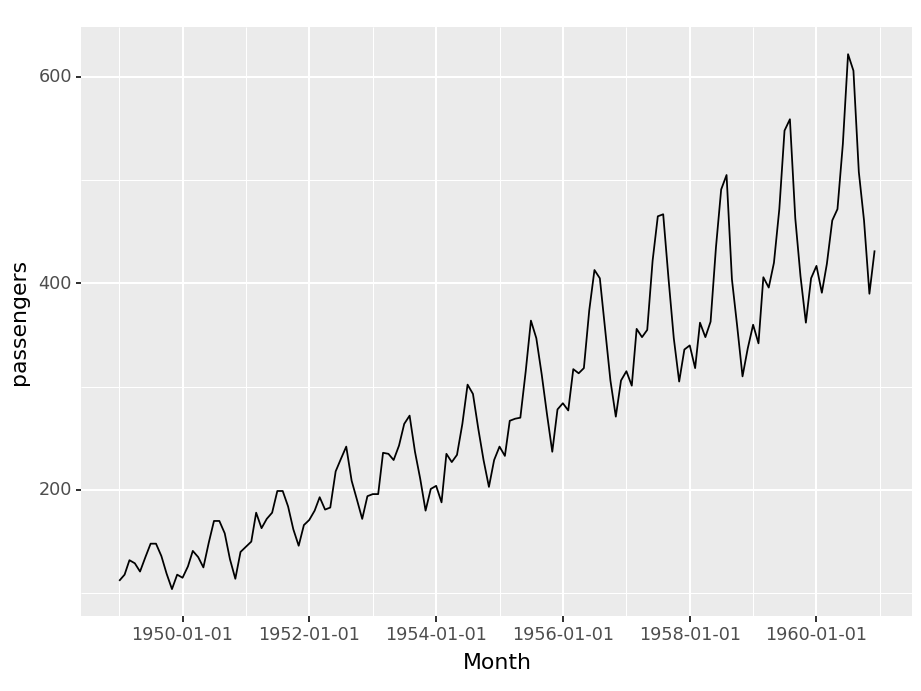

<Figure Size: (460 x 345)>

In [7]:
ggplot(air_passengers, aes(x='Month',y='passengers'))+geom_line()

There is an upward trend and the variation gets bigger over time. Getting rid of those by taking the log, then the diff of the data.

In [8]:
import numpy as np
air_passengers['log_passengers'] = np.log(air_passengers['passengers'])
air_passengers['diff_log_passengers'] = air_passengers['log_passengers'].diff()

/home/herwin/anaconda3/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


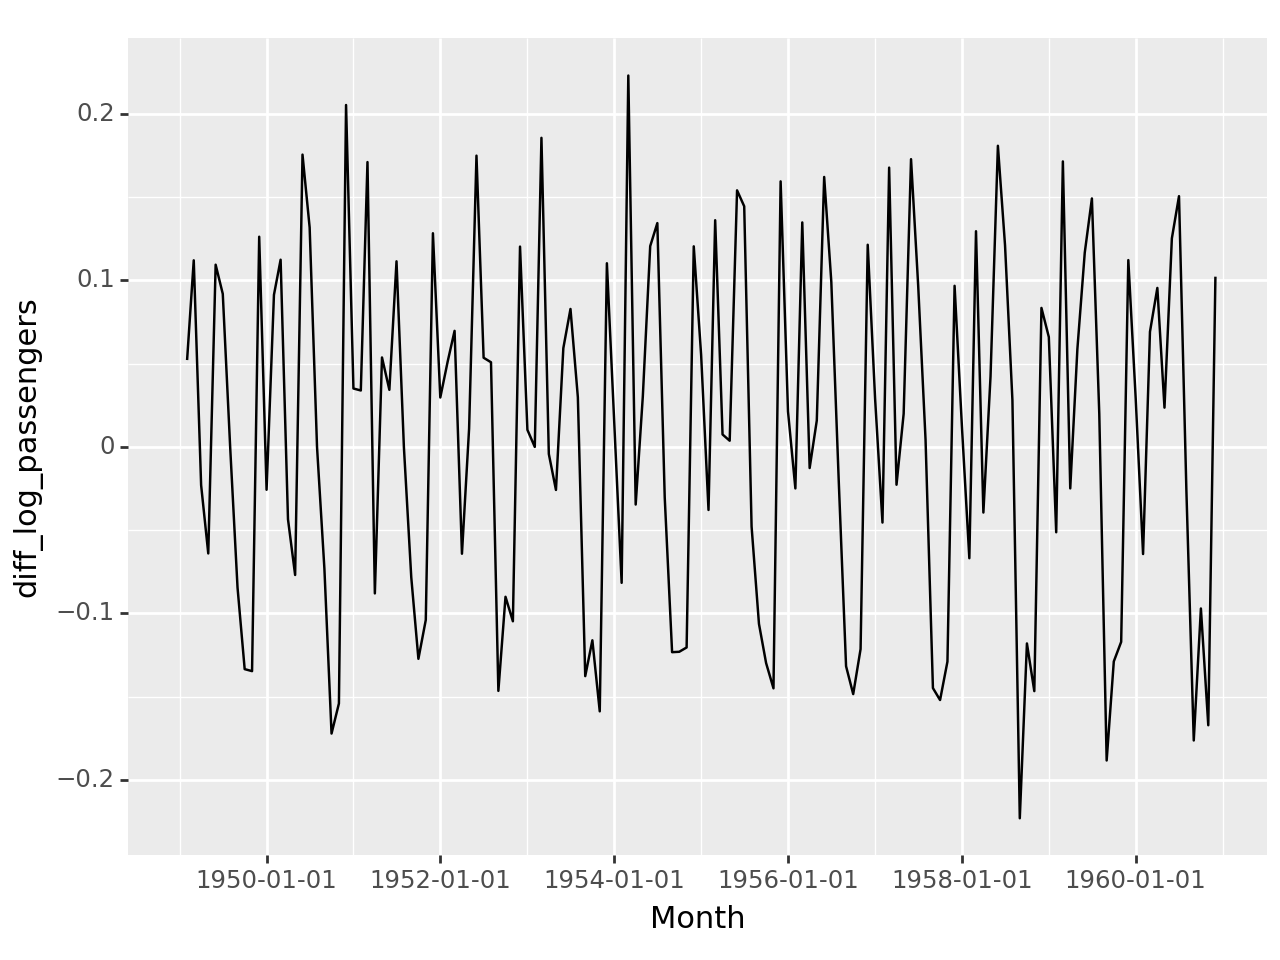

<Figure Size: (640 x 480)>

In [9]:
ggplot(air_passengers, aes(x='Month',y='diff_log_passengers'))+geom_line()

The data now seems stationary. Let's take a look at the auto-correlation.

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
air_passengers = air_passengers[1:len(air_passengers)].copy()

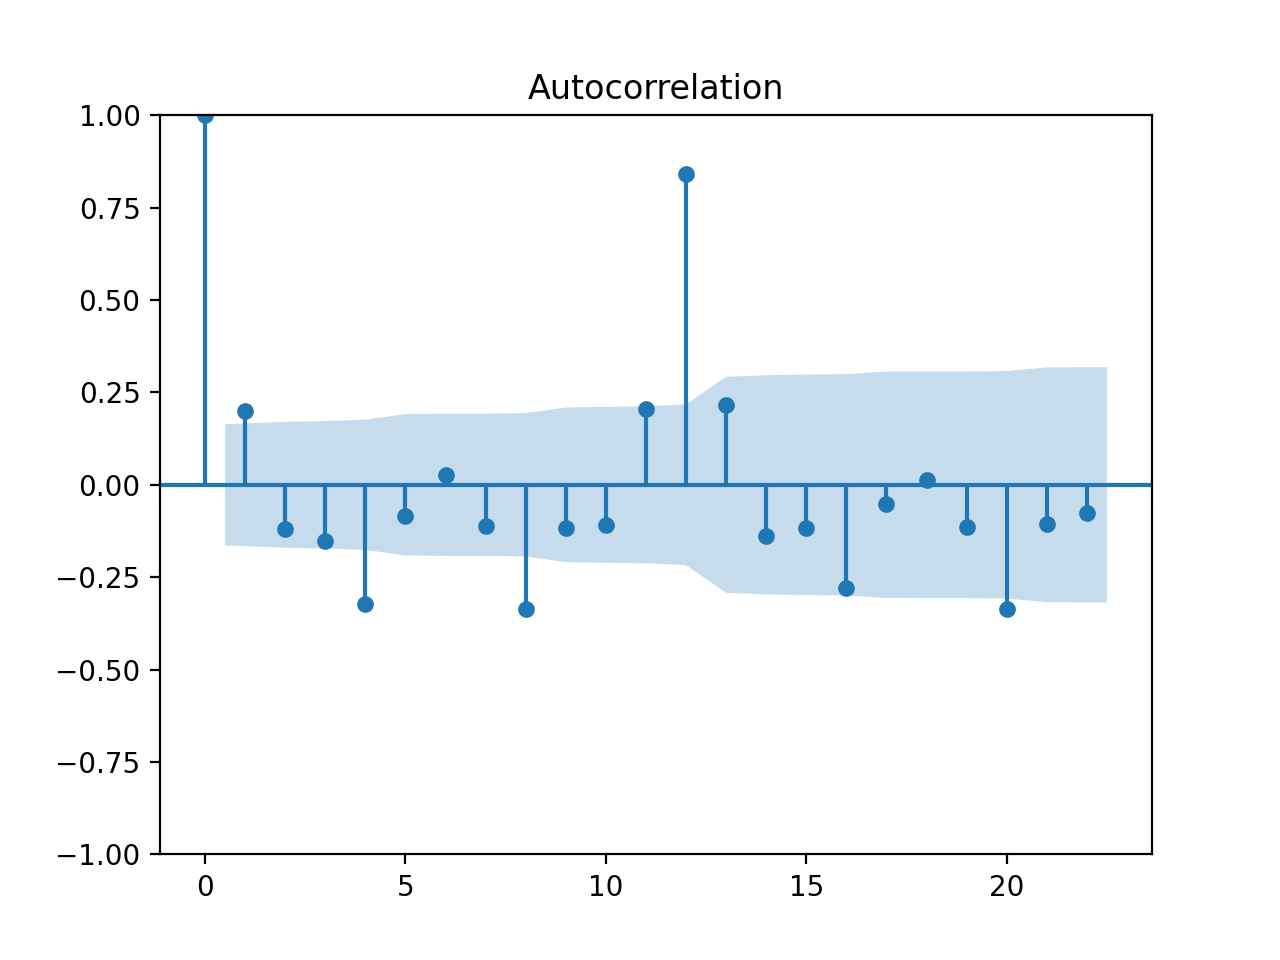

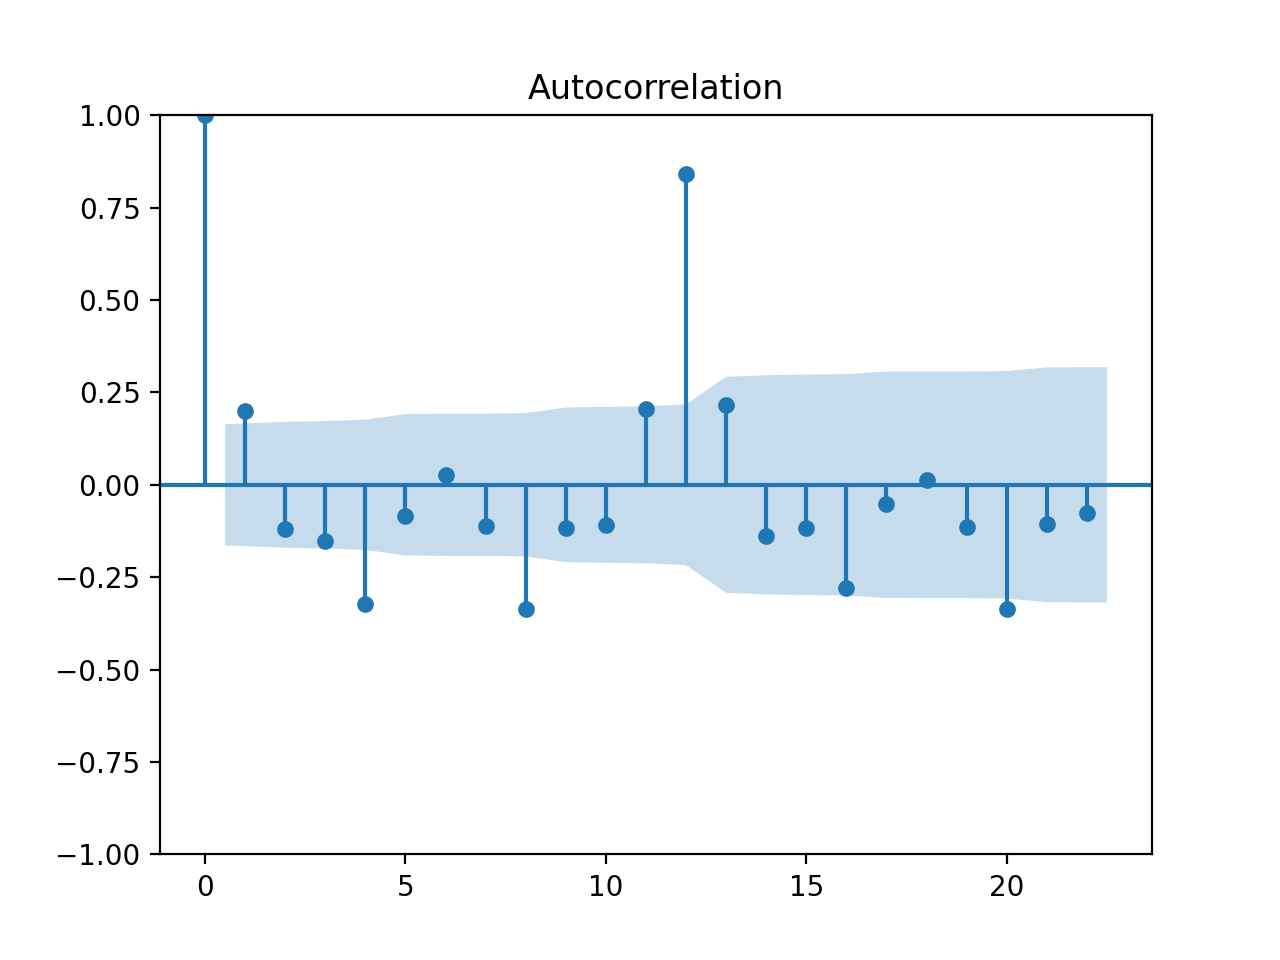

In [12]:
plot_acf(air_passengers['diff_log_passengers'])

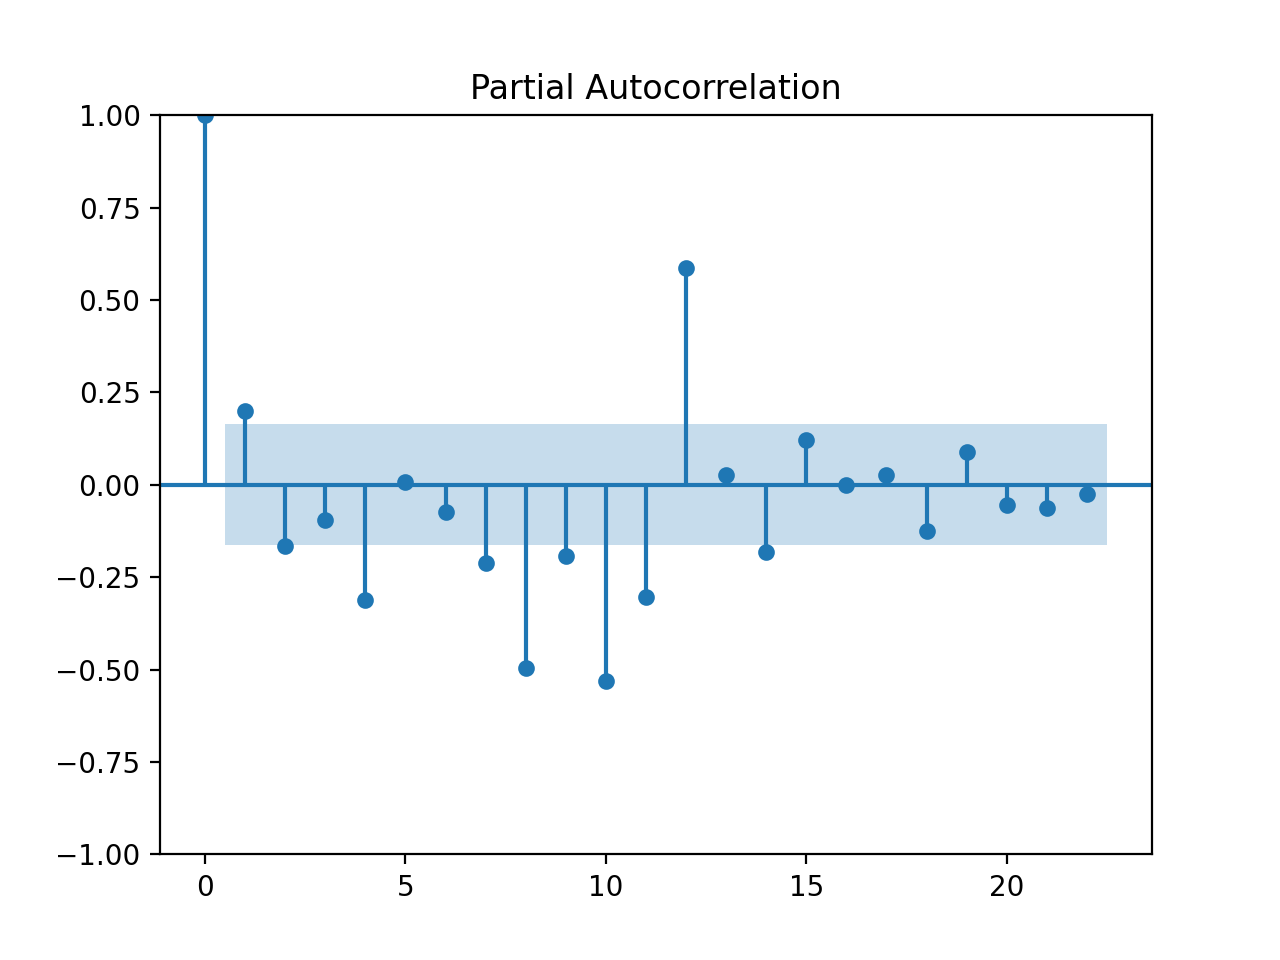

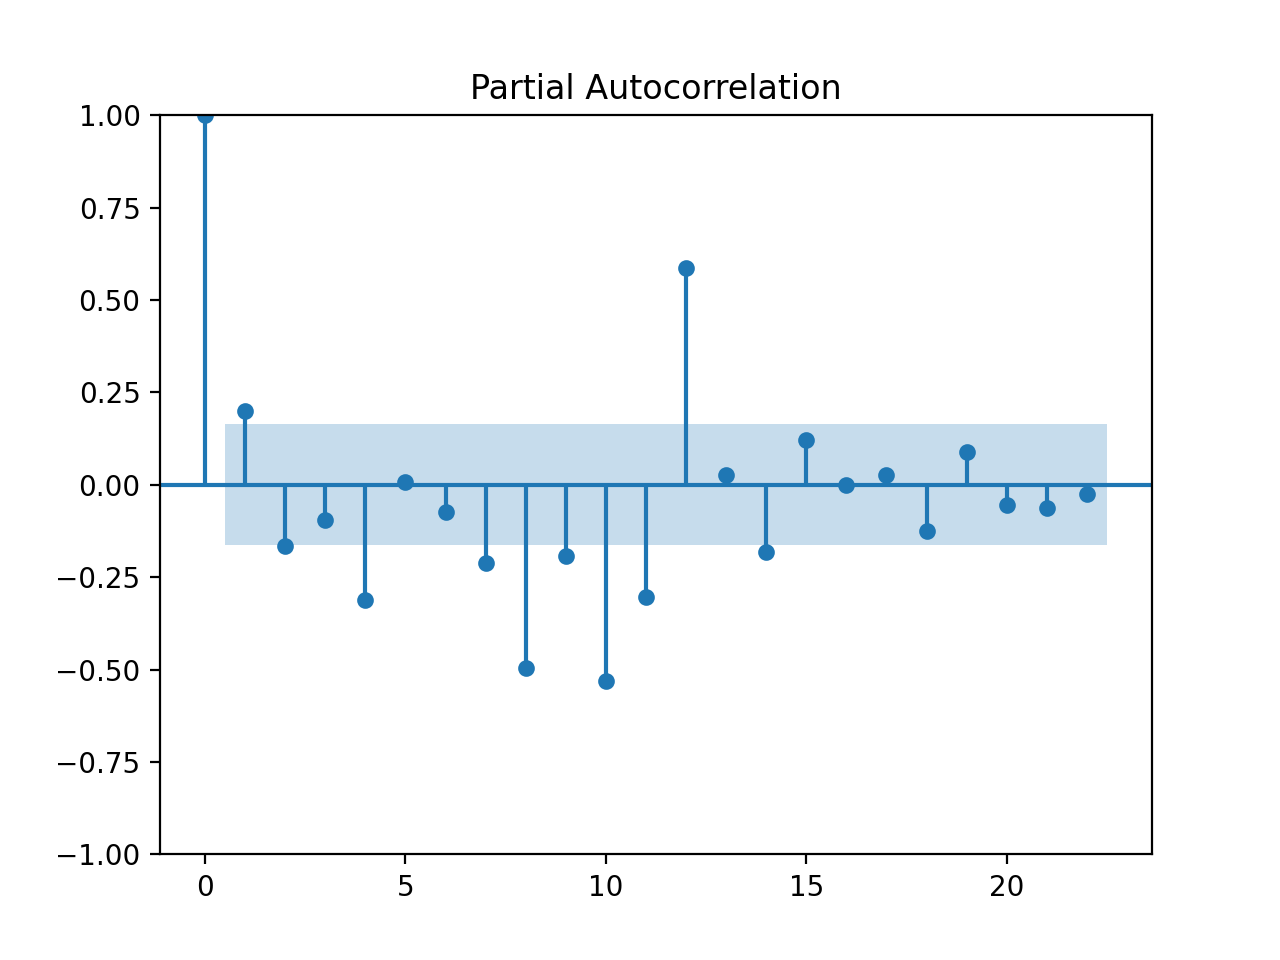

In [14]:
plot_pacf(air_passengers['diff_log_passengers'])

There seems to be a seasonal monthly correlation and some other correlations.

# Fitting a sarima model

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [76]:
model = SARIMAX(air_passengers['log_passengers'], order=(1, 1, 1), seasonal_order=(0, 0, 1, 12))

In [77]:
fit = model.fit()

In [78]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     log_passengers   No. Observations:                  143
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 167.789
Date:                            Fri, 25 Aug 2023   AIC                           -327.578
Time:                                    17:12:22   BIC                           -315.755
Sample:                                         0   HQIC                          -322.774
                                            - 143                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0622      0.861     -0.072      0.942      -1.749       1.625
ma.L1          0.1802      0.862      0.209      0.834      -1.509       1.869
ma.S.L12       0.7389      0.079      9.362      0.000       0.584       0.894
sigma2         0.0052      0.001      7.420      0.000       0.004       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.27
Prob(Q):                              0.90   Prob(JB):                         0.12
Heteroskedasticity (H):               0.94   Skew:                             0.40
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
air_passengers['pred'] = np.exp(fit.predict(start=3))

In [80]:
df_plot = air_passengers.melt(id_vars = ['Month'], value_vars=['passengers','pred'])
df_plot

,Month,variable,value
0,1949-02-01,passengers,118.000000
1,1949-03-01,passengers,132.000000
2,1949-04-01,passengers,129.000000
3,1949-05-01,passengers,121.000000
4,1949-06-01,passengers,135.000000
...,...,...,...
281,1960-08-01,pred,626.620710
282,1960-09-01,pred,575.424067
283,1960-10-01,pred,468.729191
284,1960-11-01,pred,439.270712


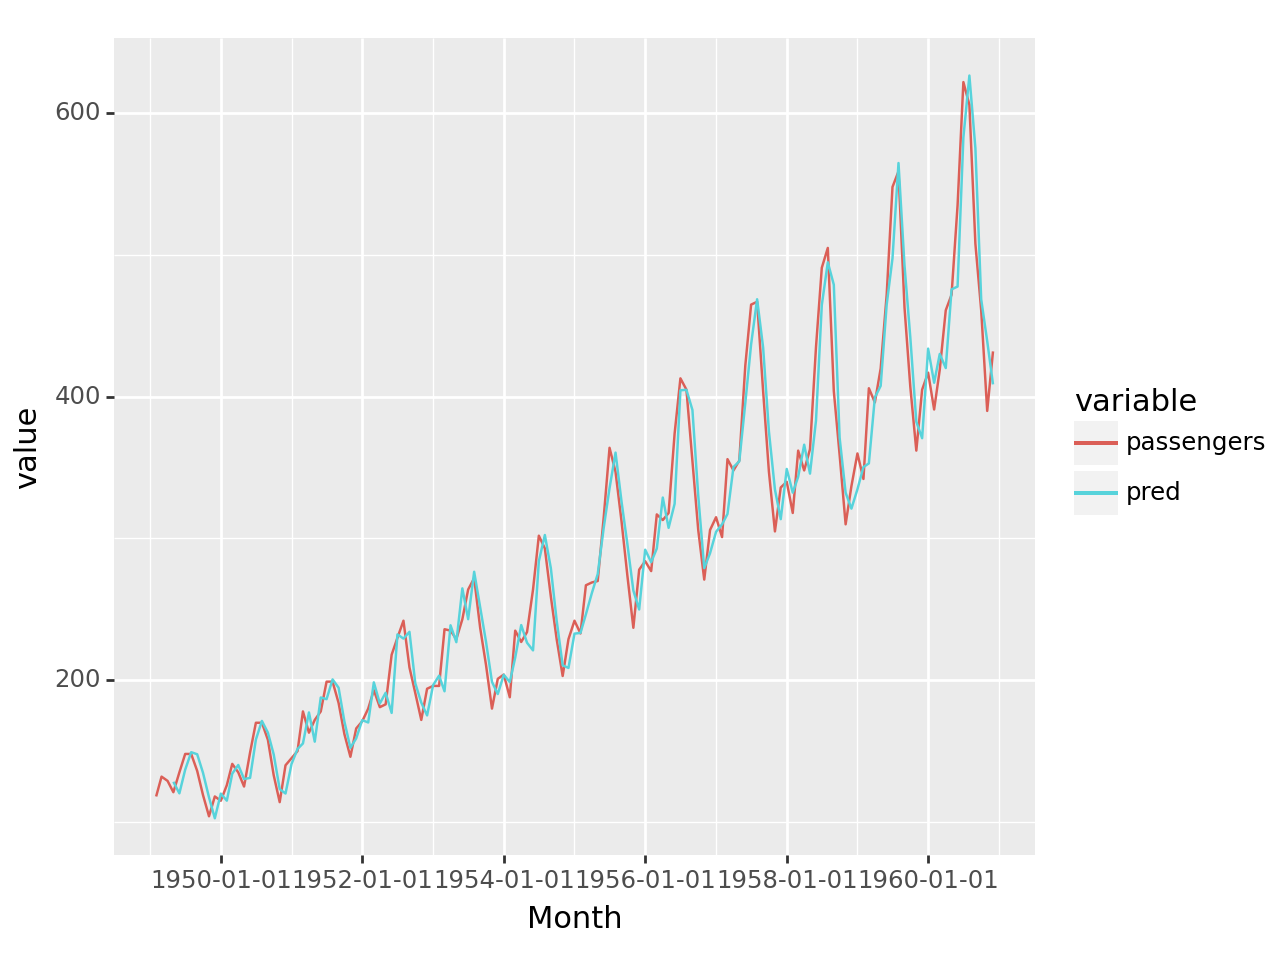

<Figure Size: (640 x 480)>

In [83]:
ggplot(df_plot, aes(x='Month',y='value', color='variable'))+geom_line()

In [84]:
air_passengers['pred']

1             NaN
2             NaN
3             NaN
4      128.350789
5      120.198305
          ...    
139    626.620710
140    575.424067
141    468.729191
142    439.270712
143    408.729374
Name: pred, Length: 143, dtype: float64